In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Przygotowanie danych

Zdecydowaliśmy nie brać pod uwagę autora utworu. Same gatunki są z nim skorelowane, ponieważ gatunki są udostępniane jako lista w jakich autor tworzy

Na pozostałych atrybutach przeprowadziliśmy backward selection. Jako funkcję celu braliśmy pod uwagę średnią wariancję atrybutów we wszystkich utworzynych grupach. W poniższej tabeli przedstawiamy wyniki kolejnych iteracji, w których wybierany był atrybut który najmniej pogarszał naszą funkcję celu. Kod programu znajduje się w pliku [selection.py](selection.py). Postanowiliśmy usunąć tylko atrybut explicit.

| Usunięty atrybut  | Średnia wariancja    |
|-------------------|--------------------- |
| None              | 0.011086775740732583 |
| explicit          | 0.017877785448255863 |
| key               | 0.024947679040287756 |
| acousticness      | 0.027180322665069444 |
| energy            | 0.030437649274463272 |
| valence           | 0.033694095208262914 |
| release_date      | 0.035882119370513874 |
| speechiness       | 0.03666206294648116  |
| liveness          | 0.038504847005265526 |
| loudness          | 0.039150961558759474 |
| danceability      | 0.04352528058903148  |
| tempo             | 0.046057781249811684 |


In [2]:
from prepare_data import prepare_grouping

# Model podstawowy

- mieszamy kolejność dataframe
- dokładamy do obecnej grupy kolejne utwory dopóki ich suma nie przekroczy godziny i następnie przechodzimy do następnej
- jeżeli ostatnia grupa ma mniej niż godzinę to ją rozdzielamy pomiędzy pozostałe

In [3]:
from grouping.base_model import base_model

# Model zaawansowany

- korzystamy z algorytmu agglomerative clustering z biblioteki scipy
- na początku każdy utwór ma przypisany unikalną grupę oraz otrzymujemy które kolejne klastry mają być łaczone
- łączymy kolejne klastry dopóki wszystkie klastry nie posiadają sumy długości utworów równej co najmniej godzinę
- na końcu jeżeli któraś grupa nie ma więcej niż godziny utworów to jej nie zwracamy

In [4]:
from grouping.advanced_model import advanced_model

TODO
- ustawienie distance_threshold lub innego warunku przerwania
lub może 20+ grup

# TESTOWANIE

In [5]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [6]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


def pca_scatter(model, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(model)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

In [7]:
prepared_data = prepare_grouping(with_onehotencoding=True)

test = prepared_data[:100]
params = test.drop(columns=['id_x', 'duration_ms'])

In [8]:
from prepare_data import jsonl2df

artists = jsonl2df("datav2/artists.jsonl")
tracks = jsonl2df("datav2/tracks.jsonl")

mock_data = pd.merge(tracks, artists, left_on="id_artist", right_on="id")

mock_data = mock_data.dropna()
mock_data = mock_data.drop(columns=["name_x", "popularity", "id_y", "name_y"])

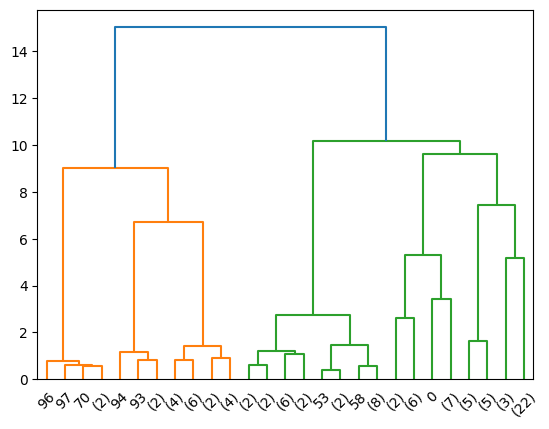

In [9]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(params)

plot_dendrogram(clustering, truncate_mode="level", p=4)

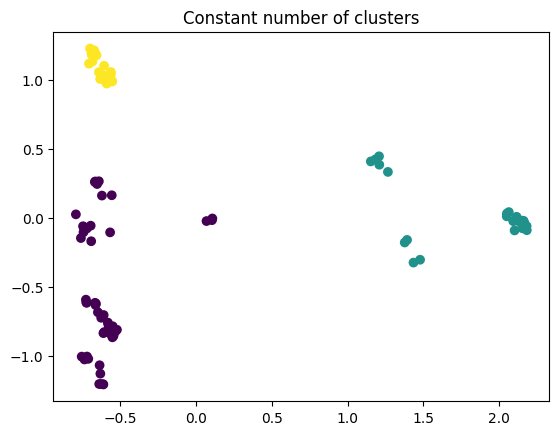

In [10]:
clustering = AgglomerativeClustering(n_clusters=3).fit(params)
labels = clustering.labels_
pca_scatter(params, labels, 'Constant number of clusters')

In [11]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([51, 25, 24]))

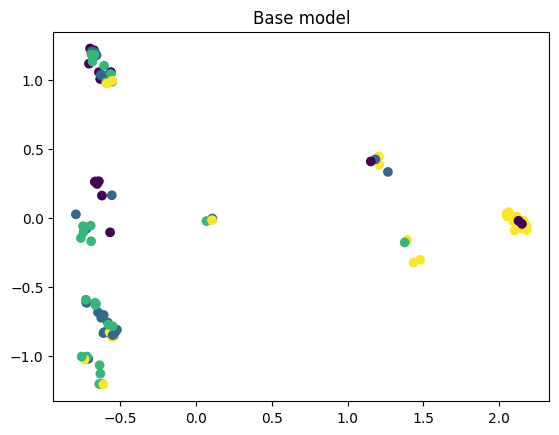

In [12]:
base = base_model(test)

labels = base['group']
pca_scatter(params, labels, 'Base model')

In [13]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([22, 25, 27, 26]))

In [14]:
group_id = labels[0]
result = base[base['group'] == group_id]['id']
first_group_base = mock_data[mock_data['id_x'].isin(result)]

In [15]:
first_group_base['duration_ms'].sum() / 1000 / 60 / 60

1.151707222222222

In [16]:
first_group_base.describe()

,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,22.000000,22.0,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,188461.181818,0.0,0.420545,0.266214,5.045455,-14.293045,0.042227,0.801318,0.033031,0.202514,0.421291,106.092864
std,62600.516930,0.0,0.160194,0.208110,3.933704,4.134112,0.010205,0.184217,0.109930,0.156786,0.296863,25.526710
min,108547.000000,0.0,0.184000,0.054600,0.000000,-22.829000,0.031200,0.383000,0.000000,0.089200,0.073400,61.188000
25%,162369.750000,0.0,0.291250,0.106500,1.250000,-16.503000,0.034525,0.677000,0.000000,0.109750,0.176000,89.267250
50%,183553.000000,0.0,0.424500,0.200000,6.000000,-13.912000,0.040650,0.872500,0.000002,0.145000,0.287500,105.647500
75%,199429.750000,0.0,0.560000,0.327750,9.000000,-11.209500,0.046300,0.949250,0.000066,0.271500,0.590750,126.522000
max,423493.000000,0.0,0.673000,0.724000,11.000000,-7.706000,0.069700,0.990000,0.449000,0.788000,0.962000,170.377000


In [17]:
first_group_base['genres'].explode().value_counts()

genres
adult standards       19
easy listening         9
lounge                 9
swing                  7
vocal jazz             7
jazz blues             6
classic rock           3
rockabilly             3
rock-and-roll          3
rock                   3
psychedelic rock       2
beatlesque             2
merseybeat             2
british invasion       2
dixieland              1
jazz trumpet           1
new orleans jazz       1
soul                   1
harlem renaissance     1
album rock             1
country rock           1
folk                   1
folk rock              1
mellow gold            1
roots rock             1
singer-songwriter      1
Name: count, dtype: int64

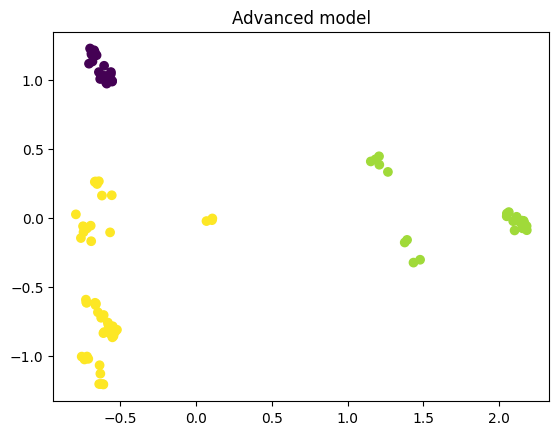

In [18]:
advanced = advanced_model(test)
labels = advanced['group']
params_dropped = test[test['id_x'].isin(advanced['id_x'])].drop(columns=['id_x', 'duration_ms', 'group'])
pca_scatter(params_dropped, np.array(labels), 'Advanced model')

In [19]:
np.unique(labels, return_counts=True)

(array([189, 195, 196]), array([24, 25, 51]))

In [20]:
group_id = labels[0]
result = advanced[advanced['group'] == group_id]['id_x']
first_group_adv = mock_data[mock_data['id_x'].isin(result)]

In [21]:
first_group_adv['duration_ms'].sum() / 1000 / 60 / 60

2.387871111111111

In [22]:
first_group_adv.describe()

,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,51.000000,51.0,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,168555.607843,0.0,0.516784,0.392155,5.470588,-11.727804,0.050878,0.767922,0.011049,0.203649,0.602118,103.223686
std,49615.654071,0.0,0.167645,0.202809,3.477660,3.957757,0.029624,0.150633,0.063335,0.150253,0.272974,31.018912
min,107280.000000,0.0,0.181000,0.037300,0.000000,-22.829000,0.026600,0.410000,0.000000,0.061400,0.143000,61.188000
25%,137833.500000,0.0,0.396000,0.257000,2.000000,-13.900000,0.031450,0.667000,0.000000,0.105000,0.379500,80.208500
50%,159920.000000,0.0,0.482000,0.365000,5.000000,-11.064000,0.042200,0.776000,0.000002,0.135000,0.609000,96.217000
75%,186327.000000,0.0,0.653000,0.556500,9.000000,-8.791000,0.057700,0.880500,0.000045,0.284000,0.879500,121.202000
max,423493.000000,0.0,0.845000,0.801000,11.000000,-5.523000,0.180000,0.990000,0.449000,0.760000,0.969000,174.797000


In [23]:
first_group_adv['genres'].explode().value_counts()

genres
adult standards       48
rock-and-roll         32
rockabilly            22
soul                  19
vocal jazz            16
jazz blues            15
classic soul          10
brill building pop    10
torch song             8
swing                  8
soul blues             6
outlaw country         3
arkansas country       3
soul jazz              2
dixieland              1
jazz trumpet           1
new orleans jazz       1
harlem renaissance     1
Name: count, dtype: int64

In [40]:
def test_data(data, count=100, shift=0, show_plot=False):
    test = data[shift:count]
    params = test.drop(columns=['id_x', 'duration_ms'])


    base = base_model(test)
    labels = base['group']
    if show_plot:
        pca_scatter(params, labels, 'Base model')
        print(np.unique(labels, return_counts=True))
    group_num_base = len(np.unique(labels, return_counts=True)[0])

    params = params.reset_index(drop=True)
    labels = labels.reset_index(drop=True)
    bas = params.assign(group=labels)

    mean_variance_group_base = bas.groupby('group').var().mean(axis=1)
    mean_variance_group_base = np.nansum(mean_variance_group_base) / len(mean_variance_group_base)


    advanced = advanced_model(test)
    labels = advanced['group']
    params_dropped = test[test['id_x'].isin(advanced['id_x'])].drop(columns=['id_x', 'duration_ms', 'group'])
    if show_plot:
        pca_scatter(params_dropped, np.array(labels), 'Advanced model')
        print(np.unique(labels, return_counts=True))
    group_num_adv = len(np.unique(labels, return_counts=True)[0])

    adv = pd.concat([params_dropped, labels], axis=1)
    mean_variance_group_adv = adv.groupby('group').var().mean(axis=1)
    mean_variance_group_adv = sum(mean_variance_group_adv) / len(mean_variance_group_adv)


    print(f"Base: group_num: {group_num_base}, variance:{mean_variance_group_base}")
    print(f"Advanced: group_num: {group_num_adv}, variance:{mean_variance_group_adv}")

    if mean_variance_group_base > mean_variance_group_adv:
        print('advanced')
    elif mean_variance_group_base < mean_variance_group_adv:
        print('base')
    else:
        print('same')

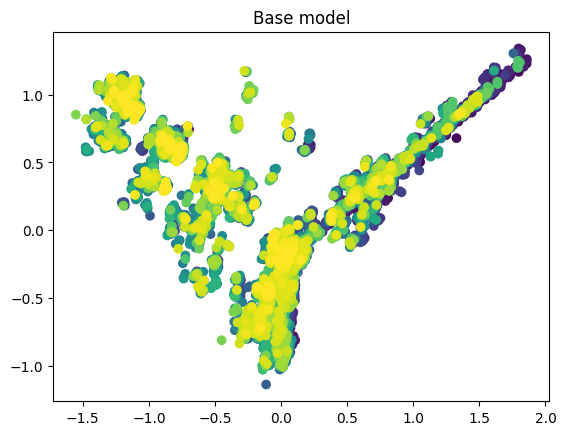

(array([   0,    1,    2, ..., 1382, 1383, 1384]), array([19, 22, 21, ..., 18, 20, 21]))


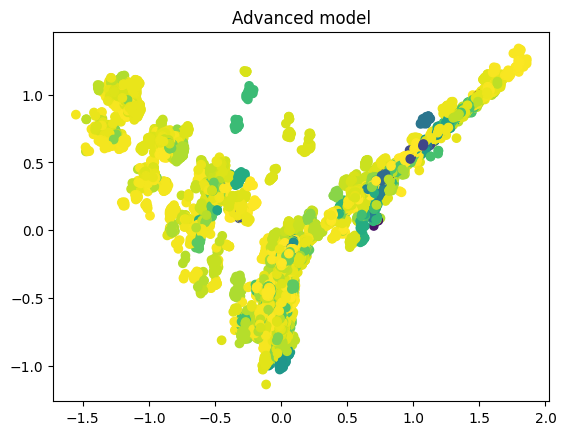

(array([42529, 42544, 42637, 42697, 42894, 42956, 42974, 43015, 43079,
       43120, 43140, 43232, 43320, 43322, 43416, 43417, 43420, 43423,
       43469, 43497, 43505, 43563, 43570, 43580, 43601, 43609, 43618,
       43643, 43646, 43648, 43661, 43663, 43687, 43707, 43708, 43740,
       43748, 43765, 43780, 43787, 43794, 43813, 43820, 43822, 43829,
       43840, 43856, 43880, 43906, 43907, 43929, 43931, 43955, 43968,
       43972, 43978, 43995, 43997, 43998, 44009, 44050, 44055, 44068,
       44081, 44093, 44104, 44109, 44110, 44128, 44131, 44151, 44166,
       44178, 44181, 44184, 44187, 44189, 44216, 44221, 44227, 44238,
       44240, 44244, 44268, 44272, 44283, 44284, 44287, 44307, 44308,
       44314, 44319, 44320, 44323, 44324, 44329, 44331, 44337, 44342,
       44346, 44351, 44352, 44353, 44354, 44355, 44357, 44363, 44364,
       44365, 44366, 44372, 44373, 44375, 44377, 44378, 44380, 44386,
       44390, 44392, 44393, 44396, 44398, 44399, 44400, 44401, 44406,
       44408, 44410

In [28]:
prepared_data = prepare_grouping()
test_data(prepared_data, len(prepared_data), show_plot=True)

In [41]:
for i in range(4):
    print(f"{i*4000}:{4000+i*4000}")
    prepared_data = prepare_grouping()
    test_data(prepared_data, 4000+i*4000, i*4000)

0:4000
Base: group_num: 269, variance:0.035508432865955876
Advanced: group_num: 36, variance:0.01323472773030386
advanced
4000:8000
Base: group_num: 255, variance:0.04218567918085856
Advanced: group_num: 32, variance:0.013781521162234344
advanced
8000:12000
Base: group_num: 240, variance:0.04551534760330001
Advanced: group_num: 41, variance:0.01274333539154135
advanced
12000:16000
Base: group_num: 245, variance:0.03902323681097264
Advanced: group_num: 51, variance:0.012768026216100401
advanced


# Podsumowania:

Oba modele jako wynik zwracają dataframe mający 2 kolumny id_utworu oraz grupę do której został przypisany.

Przeprowadziliśmy testy 4-krotnie dla obu modeli dając im 4000 utworów czyli tyle ile ok. będą otrzymywały od poprzedniego zadania rankingowania. Zmierzylśmy ile powstawało grup oraz jak była średnia wariancja w grupach. Oba zadania spełniły kryterium sukcesu biznesowe dotyczącego tego że ma powstać przynajmniej 20 grup. Natomiast model zaawansowany tworzy grupy które mają mniejszą wariancję w grupie co za tym idze są one bardziej jednorodne.